# I. Preparing the data

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import imutils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [4]:
listOfFiles = os.listdir('masks')

def random_image(debug = False):
    file = 'masks/'+listOfFiles[np.random.randint(0,1244)]
    if debug == True: print(file)
    return file

## I.1 Defining boxes

Using the masks we define the boxes subdviding the height in the number of digits. On our dataset the water mater have 5 or eight digits, and we can get this information using the file name.

In [5]:
def annotate_boxes(file):
       
    decode = file.split('/')[-1].split('_')
    if decode[4].split('.')[0] == '0':
        n_digits = 5
        measurement = decode[3].zfill(5)
    else: 
        n_digits = 8
        measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)
            
    c_id = file.split('/')[-1].split('.')[0]
    
    gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.imread('data/water_meter/images/'+file.split('/')[1])
    
    cnt = []
    contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = contours[0]
    
    # Calculating the box
    #--------------------------
    # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
    #--------------------------
    x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)
    #cv2.rectangle(img,(x_box,y_box),(x_box+w_box,y_box+h_box),(0,255,0),2)
    area_bounding = w_box*h_box
            
    # Calculating the minimal box
    #--------------------------
    # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
    #--------------------------
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    box = box[np.argsort(box[:,0])]
    p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
    box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
    box_ = box_[np.argsort(box_[:,1])]
        
    if box_[0,0] > box_[1,0]:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
    else:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]

    if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
        angle = np.arctan(h_box/w_box)
        position = 'h'
        w = int(np.ceil(w_box/n_digits))
        x = x_box
        y = y_box
        h = h_box
        for i in range(0, n_digits):
            cv2.rectangle(img, (x,y),(x+w,y+h), (0,0,255-10*i),5)
            x += w                      
    else:
        ref = box[0] # reference point
        ver = box[1:,][np.argmin(box[1:,1])] # second vertice
        dif = ver-ref
        angle = np.degrees(np.arctan(dif[1]/dif[0]))
        if angle < 5: 
            angle = 0
        position = 'v'
        angle += 90   
        
        x = x_box
        y = y_box
        w = w_box #abs(p_min_y_max_x[0] - p_min_xy[0])
        h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
        for i in range(0, n_digits):
            cv2.rectangle(img, (x,y),(x+w,y+h), (0,0,255),5)
            y += h    
    
    plt.rcParams["figure.figsize"] = (15,10)    
    plt.title('image')
    plt.axis("off")
    plt.imshow(img)

    return box, angle, p_min_xy, p_max_y_min_x, p_max_xy, p_min_y_max_x

masks/id_5_value_100_533.jpg
Wall time: 111 ms


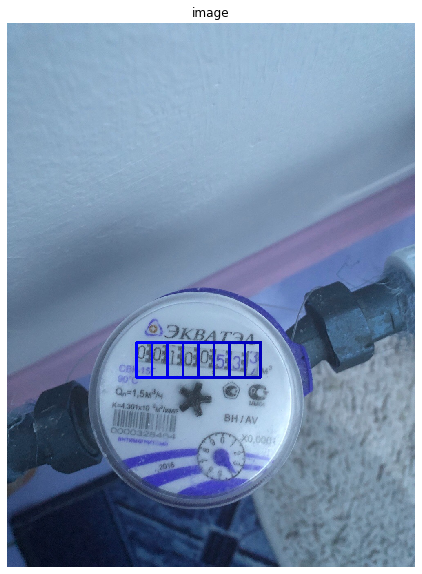

In [6]:
%%time
box, angle, p_min_xy, p_max_y_min_x, p_max_xy, p_min_y_max_x = annotate_boxes(random_image(True))

## I.2 Generating annotation files

We need to create a .txt file for each .jpg image in the same directory and with the same name, but with .txt extension, and put to file: object number and object coordinates on this image, for each object in new line:

<object-class> <x_center> <y_center> <width> <height>

    
    
Where:

<object-class> - integer object number from 0 to (classes-1)
<x_center> <y_center> <width> <height> - float values relative to width and height of image, it can be equal from (0.0 to 1.0]
for example: <x> = <absolute_x> / <image_width> or <height> = <absolute_height> / <image_height>
atention: <x_center> <y_center> - are center of rectangle (are not top-left corner)
For example for img1.jpg you will be created img1.txt containing:

In [8]:
def generate_file_annotations(file, directory):
    
    """Generates annotations for a given file creating a txt file in the directory"""
    
    #Number of digits - is used to define the number of boxes
    decode = file.split('/')[-1].split('_')
    if decode[4].split('.')[0] == '0':
        n_digits = 5
        measurement = decode[3].zfill(5)
    else: 
        n_digits = 8
        measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)
            
    c_id = file.split('/')[-1].split('.')[0]
    
    gray = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    
    height, width = gray.shape
    
    cnt = []
    contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cnt = contours[0]
    
    # Calculating the box
    #--------------------------
    # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
    #--------------------------
    x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)
            
    # Calculating the minimal box
    #--------------------------
    # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
    #--------------------------
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    box = box[np.argsort(box[:,0])]
    p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
    box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
    box_ = box_[np.argsort(box_[:,1])]
        
    if box_[0,0] > box_[1,0]:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
    else:
        p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]

        
    with open(directory+'/' + c_id +'.txt', 'w') as f:

        if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
            w = int(np.ceil(w_box/n_digits))
            x = x_box
            y = y_box
            h = h_box
            for i in range(0, n_digits):
                x_center = str((x + w/2)/width)
                y_center = str((y + h/2)/height)
                f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                x += w                      
        else:
            x = x_box
            y = y_box
            w = w_box 
            h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
            for i in range(0, n_digits):
                x_center = str((x + w/2)/width)
                y_center = str((y + h/2)/height)
                f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                y += h    

In [9]:
generate_file_annotations(random_image(True),'data/water_meter/labels')

masks/id_485_value_137_551.jpg


In [7]:
def generate_annotations(src, dst):
    
    """Generates annotations for the files in the src directory creating a txt file in the dst folder"""
    
    listOfFiles = os.listdir(src)
    
    for file in listOfFiles:

        decode = file.split('_')
        if decode[4].split('.')[0] == '0':
            n_digits = 5
            measurement = decode[3].zfill(5)
        else: 
            n_digits = 8
            measurement = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)

        c_id = file.split('.')[0]

        gray = cv2.imread(src+'/'+file, cv2.IMREAD_GRAYSCALE)

        height, width = gray.shape

        cnt = []
        contours = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        cnt = contours[0]

        # Calculating the box
        #--------------------------
        # cv2.boundingRect() returns (x,y) the top-left coordinate of the rectangle and (w,h) the width and height
        #--------------------------
        x_box,y_box,w_box,h_box = cv2.boundingRect(cnt)

        # Calculating the minimal box
        #--------------------------
        # cv2.minAreaRect() returns a Box2D structure ( center (x,y), (width, height), angle of rotation ). 
        #--------------------------
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        box = box[np.argsort(box[:,0])]
        p_min_xy = box[1] if box[0,1] >  box[1,1] else box[0]
        box_ = box[np.array(np.abs(np.all(box == p_min_xy, axis = 1)-1), dtype=bool)]
        box_ = box_[np.argsort(box_[:,1])]

        if box_[0,0] > box_[1,0]:
            p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[1], box_[2], box_[0] 
        else:
            p_max_y_min_x, p_max_xy, p_min_y_max_x = box_[0], box_[2], box_[1]


        with open(dst+'/' + c_id +'.txt', 'w') as f:

            if np.linalg.norm([p_min_xy, p_min_y_max_x]) > np.linalg.norm([p_min_xy,p_max_y_min_x]):
                w = int(np.ceil(w_box/n_digits))
                x = x_box
                y = y_box
                h = h_box
                for i in range(0, n_digits):
                    x_center = str((x + w/2)/width)
                    y_center = str((y + h/2)/height)
                    f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                    x += w                      
            else:
                x = x_box
                y = y_box
                w = w_box 
                h = int(np.ceil(abs(p_max_y_min_x[1]-p_min_xy[1])/n_digits))
                for i in range(0, n_digits):
                    x_center = str((x + w/2)/width)
                    y_center = str((y + h/2)/height)
                    f.write(measurement[i]+' '+x_center+' '+y_center+' '+str(w/width)+' '+str(h/height)+'\n')
                    y += h

In [156]:
generate_annotations('masks', 'data/water_meter/labels')